In [1]:
import cveig
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import binom
import pickle
from tqdm.autonotebook import tqdm
import seaborn as sns

<ipython-input-1-bf68ba4e83d5>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
k = 10
n_tries = 10
expected_degrees = np.arange(25, 61, 5)
thetas = ['point', 'exp', 'pareto']

In [3]:
results = np.empty((n_tries, len(expected_degrees), len(thetas), 4))

for d, degree in enumerate(tqdm(expected_degrees)):
    for i in tqdm(range(n_tries)):
        for j, theta in enumerate(thetas):
            file = f'../../masters_r/samples_poiss/graph_{theta}_{degree}_{i+1}.table'
            # print(file)
            adj_matrix = pd.read_table(file, sep=' ').to_numpy()
                
            adj_matrix = sparse.csr_array(adj_matrix)

            results[i, d, j, 0] = cveig.eig_cv(adj_matrix, 15, 0.1, folds=1)
            results[i, d, j, 1] = cveig.eig_cv(adj_matrix, 15, 0.1, folds=5)
            results[i, d, j, 2] = cveig.eig_cv(adj_matrix, 15, 0.1, folds=10)
            results[i, d, j, 3] = cveig.eig_cv(adj_matrix, 15, 0.1, folds=15)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
with open('results_folds_poiss2.pickle', 'wb') as f:
    pickle.dump(results, f)

In [5]:
with open('results_folds_poiss2.pickle', 'rb') as f:
    results = pickle.load(f)

In [6]:
avg_results = np.mean(results, axis=(0))

In [7]:
labels = ['1', '5', '10', '15']
titles = [
    'Point distribution',
    'Exponential distribution',
    'Pareto distribution',
    ]

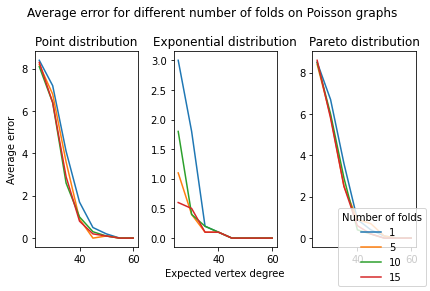

In [8]:
fig, ax = plt.subplots(1,3)

for i, title in enumerate(titles):
    ax[i].set_title(title)
    for j, label in enumerate(labels):
        ax[i].plot(expected_degrees, np.abs(avg_results[:, i, j] - 10), label=label)

ax[0].set_ylabel('Average error')
ax[1].set_xlabel('Expected vertex degree')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', title='Number of folds')
fig.suptitle('Average error for different number of folds on Poisson graphs')
fig.tight_layout()
fig.savefig('test_folds_poiss.png')

In [9]:
names = ['sample', 'degree', 'theta', 'nfolds']
thetas = ['point', 'exp', 'pareto']
folds = [1, 5, 10, 15]
labels = [np.arange(n_tries), expected_degrees, thetas, folds]

In [10]:
index = pd.MultiIndex.from_product(labels, names=names)
result_df = pd.DataFrame(results.reshape(-1, 1),index=index)
result_df.columns = ['value']
result_df['error'] = np.abs(result_df.value - 10)

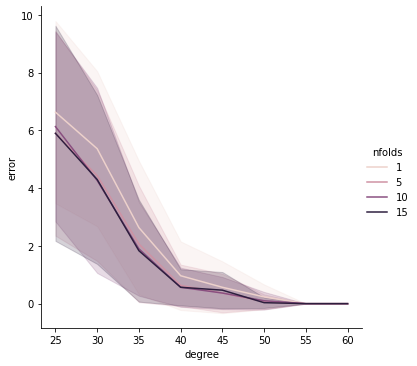

In [11]:
sns.relplot(x="degree", y="error", kind="line", ci="sd", data=result_df, hue='nfolds')

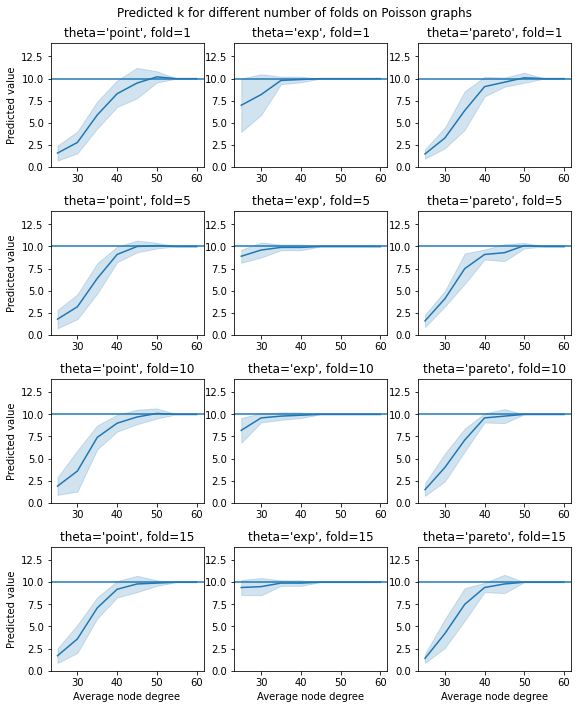

In [12]:
fig, ax = plt.subplots(4,3, figsize=(8,10))
degrees = []
for i, fold in enumerate(folds):
    for j, theta in enumerate(thetas):
        # ax[i, j].set_title(theta)
        sns.lineplot(
            x="degree", 
            y="value", 
            ci="sd", 
            data=result_df.loc[:, :, theta, fold], 
            ax=ax[i, j],
            )
        ax[i,j].set_ylim(0, 14)
        ax[i,j].set_title(f'{theta=}, {fold=}')
        ax[i,j].axhline(10)
        if i<3: 
            ax[i,j].set_xlabel(None)
        else:
            ax[i,j].set_xlabel('Average node degree')
        if j>0: 
            ax[i,j].set_ylabel(None)
        else:
            ax[i,j].set_ylabel('Predicted value')



#ax[0].set_ylabel('Average error')
#ax[1].set_xlabel('Expected vertex degree')
#handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', title='Number of folds')
fig.suptitle('Predicted k for different number of folds on Poisson graphs')
fig.tight_layout()
fig.savefig('test_folds2_poiss.png')

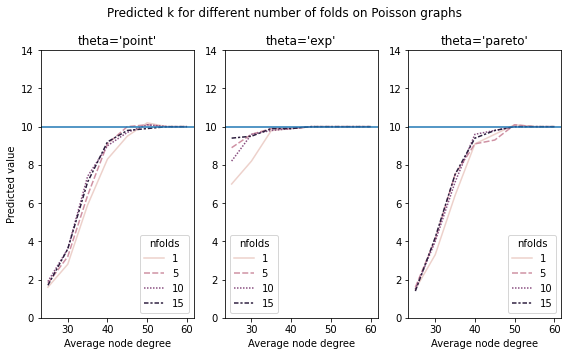

In [13]:
fig, ax = plt.subplots(1,3, figsize=(8,5))
degrees = []
for j, theta in enumerate(thetas):
    # ax[i, j].set_title(theta)
    sns.lineplot(
        x="degree", 
        y="value", 
        ci=None, 
        data=result_df.loc[:, :, theta, :], 
        ax=ax[j],
        hue='nfolds',
        style='nfolds',
        )
    ax[j].set_ylim(0, 14)
    ax[j].set_title(f'{theta=}')
    ax[j].axhline(10)
    ax[j].set_xlabel('Average node degree')
    ax[j].set_ylabel('Predicted value')
    if j>0: ax[j].set_ylabel(None)



#ax[0].set_ylabel('Average error')
#ax[1].set_xlabel('Expected vertex degree')
#handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', title='Number of folds')
fig.suptitle('Predicted k for different number of folds on Poisson graphs')
fig.tight_layout()
fig.savefig('test_folds3_poiss.png')